# Satellite Tracker

In [1]:
# Installing the necessary dependencies
%pip install matplotlib numpy skyfield ephem datetime pytz

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt

import ephem
from skyfield import api
from datetime import datetime
from pytz import timezone

## Data Fetching and Calculations

In [3]:
# Function to fetch satellite information TLE given the satellite name as a string and the source link as a string
def satellite_info(satellite_name, link):
    satellites_data = api.load.tle(link)
    try:
        info = satellites_data[satellite_name]
    except KeyError:
        info = f"Satellite {satellite_name} not found in the dataset"
    return info

In [4]:
# Fetching the data for an arbitrary satellite and printing it
link = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=tle'
satellite_name = 'GSAT-7A'
satellite = satellite_info(satellite_name, link)
print(satellite)

GSAT-7A catalog #43864 epoch 2025-01-10 02:14:43 UTC


In [5]:
# Function to generate the time range of observation of the satellite given the start data/timing and the duration of observation
# NOTE: The start_date is provided as a tuple of (year, month, day, hour)
def generate_time_range(start_date, duration_hours):
  if duration_hours <= 0:
    raise ValueError("Duration must be a positive integer.")

  time_scale = api.load.timescale()

  minutes = range(60 * duration_hours)
  year, month, day, hour = start_date
  time_range = time_scale.utc(year, month, day, hour, minutes)

  return time_range

In [6]:
# Arbitrary Start Time and Duration for observation
start_date = (2025, 1, 9, 11)
duration_hours = 2
time_range = generate_time_range(start_date, duration_hours)

In [7]:
# Function to calculate the Altitudes and Azimuths given the Observer Coordinates
# NOTE: Observer_coords are given as a tuple in the format ('XX.XXXX N/S', 'XX.XXXX E/W')
def calculate_altaz(satellite, observer_coords, time_range):
    latitude, longitude = observer_coords
    observer = api.Topos(latitude=latitude, longitude=longitude)

    orbit = (satellite - observer).at(time_range)
    altitudes, azimuths, distances = orbit.altaz()

    return altitudes, azimuths

In [8]:
# Arbitrary Observer Coordinates for Obersation
observer_coords = ('28.6139 N', '77.2090 E') # Coordinates for New Delhi, India
altitudes, azimuths = calculate_altaz(satellite, observer_coords, time_range)

## Satellite Path Visualization

In [9]:
# Function for plotting the Satellite Path using Altitudes and Azimuths
def plot_satellite_path(altitudes, azimuths, satellite_name=""):
    plt.figure(figsize=(10, 5))
    plt.plot(azimuths.degrees, altitudes.degrees, marker='o', linestyle='-')
    if satellite_name != "":
      plt.title(f"Satellite Path - {satellite_name}")
    else:
      plt.title("Satellite Path")
    plt.xlabel("Azimuth (degrees)")
    plt.ylabel("Altitude (degrees)")
    plt.grid(True)
    plt.show()

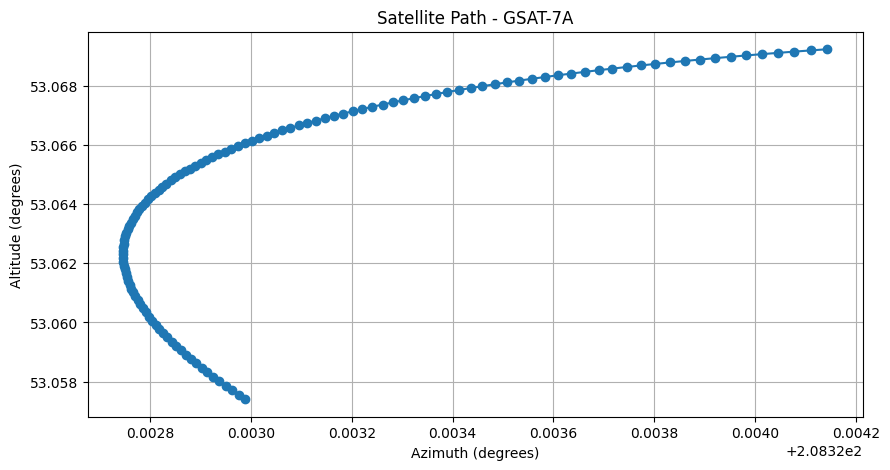

In [10]:
# Plot the path for the arbitrary satellite
plot_satellite_path(altitudes, azimuths, satellite.name)

## Polar Chart Visualization

In [11]:
# Set Time Zone
time_zone = timezone('Asia/Kolkata')

In [12]:
def get_passes(altitudes):
  visible_pass = altitudes.degrees > 0
  boundaries, = np.diff(visible_pass).nonzero()
  if len(boundaries) % 2 != 0:
    boundaries = boundaries[0: -1]
  passes = boundaries.reshape(len(boundaries) // 2, 2)

  return passes

In [13]:
passes = get_passes(altitudes)

In [14]:
def get_rise_set(passes, satellite_name=""):
  pass_to_observe = 0
  try:
    specific_pass = passes[pass_to_observe]
  except IndexError:
    print(f'{satellite_name if satellite_name != "" else "Satellite"} does not rise or set during the observed time period')
    return 0, 1
  rise_idx, set_idx = specific_pass
  print(f'{satellite_name if satellite_name != "" else "Satellite"} Rises at {time_range[rise_idx].astimezone(time_zone)}')
  print(f'{satellite_name if satellite_name != "" else "Satellite"} Sets at {time_range[set_idx].astimezone(time_zone)}')

  return rise_idx, set_idx

In [15]:
rise_idx, set_idx = get_rise_set(passes, satellite.name)

GSAT-7A does not rise or set during the observed time period


In [16]:
def plot_polar_chart(altitudes, azimuths, rise_idx, set_idx, satellite_name=""):
  ax = plt.subplot(111, projection='polar')
  plt.title(f'{satellite_name if satellite_name != "" else "Satellite"} Pass Polar Chart', pad=30)
  ax.set_rlim([0, 100])
  ax.set_theta_zero_location('N')
  ax.set_theta_direction(-1)

  θ = azimuths.radians
  r = 90 - altitudes.degrees
  ax.plot(θ[rise_idx:set_idx], r[rise_idx:set_idx], 'bo--')

  for k in range(rise_idx, set_idx):
      text = time_range[k].astimezone(time_zone).strftime('%H:%M')
      ax.text(θ[k], r[k], text, ha='right', va='bottom')

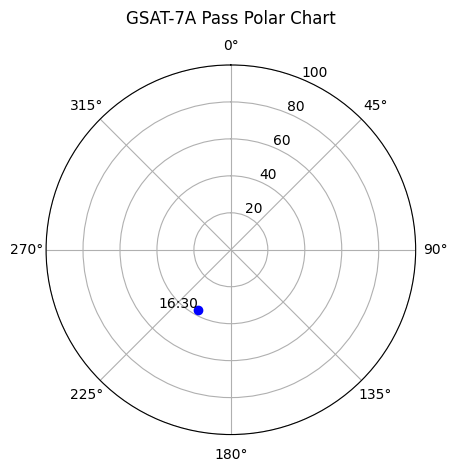

In [17]:
plot_polar_chart(altitudes, azimuths, rise_idx, set_idx, satellite.name)